# Notebook 2 — Data Cleaning

## 2.1 Attribute Selection
- Drop columns with >50% missing values
- Keep attributes relevant to ML and the Department target

## 2.2 Data Transformation / Standardization
- Lowercase text fields, trim spaces
- Type conversion for date/number fields

## 2.3 Missing Values Handling
- Strategy: text → empty string; numeric dates → retain NaN (or justify simple imputation)
- Note: avoid aggressive imputation; document rationale

## 2.4 Deduplication
- Remove exact duplicates; optionally discuss fuzzy duplicate detection

## 2.5 Class Imbalance Handling
- Options: keep all classes + report macro-F1 OR group rare departments into 'Other' (choose and justify)

## 2.6 Post-Cleaning DQ Re-Assessment
- Show improved completeness, duplicate reduction, and distributional changes

Notes: Implement the minimal, well-justified cleaning steps only; preserve interpretability for slides.

Importing Dataset

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import recordlinkage
import gc

In [3]:
MET_MUSEUM_OBJECTS = pd.read_csv("./met_museum_objects.csv")

C:\Users\Francesco\AppData\Local\Temp\ipykernel_30744\2565291987.py:1: DtypeWarning: Columns (7,8,9,10,11,18,27,28,29,30,31,32,33,34,35,36,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  MET_MUSEUM_OBJECTS = pd.read_csv("./met_museum_objects.csv")


2.1 Attribute Selection

In [ ]:
# We identify columns with more than 50% missing values first
to_delete = []
for c in MET_MUSEUM_OBJECTS.columns:
    if MET_MUSEUM_OBJECTS[c].isnull().sum() > MET_MUSEUM_OBJECTS.shape[0]/2:
        to_delete.append(c)

# TODO analyze columns better to see if it's worth keeping some

In [37]:
# We are also dropping some more additional columns because they aren't useful for our purposes
manual_deletions = ["Metadata Date", "Repository"] # Fully constant columns
manual_deletions.append("Object Date") # Redundant field already present in Object begin date and Object end date (which have 100% completeness)
to_delete = to_delete + manual_deletions

In [38]:
# Now we drop them
MODIFIED_DATASET = MET_MUSEUM_OBJECTS.drop(columns=to_delete)

2.2 Data Transformation / Standardization

In [ ]:
# Removing possible initial and final whitespace from text objects
text_cols = MODIFIED_DATASET.select_dtypes(include='object').columns

# Loop for counting how many values were cleaned
for col in text_cols:
    has_whitespace = (MODIFIED_DATASET[col] != MODIFIED_DATASET[col].str.strip()) & MODIFIED_DATASET[col].notna()
    count = has_whitespace.sum()
    
    if count > 0:
        print(f"Column '{col}': {count} values cleaned")

# Loop for actually deleting whitespaces
for col in text_cols:
    MODIFIED_DATASET[col] = MODIFIED_DATASET[col].str.strip()

Column 'Object Name': 1192 values cleaned
Column 'Title': 413 values cleaned
Column 'Artist Display Name': 140 values cleaned
Column 'Artist Alpha Sort': 2198 values cleaned
Column 'Medium': 3295 values cleaned
Column 'Dimensions': 7588 values cleaned
Column 'Credit Line': 2944 values cleaned


2.3 Missing values handling

In [ ]:
# Empty string for object fields
text_cols = MODIFIED_DATASET.select_dtypes(include=['object']).columns

# Filling missing values (NaN) with an empty string ""
MODIFIED_DATASET[text_cols] = MODIFIED_DATASET[text_cols].fillna('') # Only keep for some of the columns. Infer some through other methods

Missing values in text columns after filling:
Object Number          0
Department             0
Object Name            0
Title                  0
Artist Role            0
Artist Display Name    0
Artist Alpha Sort      0
Medium                 0
Dimensions             0
Credit Line            0
Classification         0
Link Resource          0
dtype: int64


2.4 Deduplication

In [ ]:
# Exact duplicates aren't present because there are unique columns

# Fuzzy duplicate detection
# Check if by removing unique IDs there are duplicates

Dataset Size: 448203 rows
Generating candidate pairs (this might still take a moment, but won't crash)...
Candidate Pairs to Compare: 398374723


Outlier detection

In [ ]:
def IQR(data):
    sorted(data)
    Q1, Q3 = np.percentile(data, [25, 75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    outliers = data[((data < lower_range) | (data > upper_range))]
    # print outliers
    print("The detected outliers are: ", str(outliers))

num_cols = MODIFIED_DATASET.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    IQR(MODIFIED_DATASET[col])

    # TODO possibly delete

The detected outliers are:  Series([], Name: Object ID, dtype: int64)
The detected outliers are:  2401      0
7095      0
9204      0
11774     0
11916     0
         ..
447798    0
447888    0
448042    0
448043    0
448045    0
Name: Object Begin Date, Length: 74849, dtype: int64
The detected outliers are:  2401      0
7095      0
9204      0
11774     0
11916     0
         ..
447798    0
447888    0
448042    0
448043    0
448045    0
Name: Object End Date, Length: 70352, dtype: int64


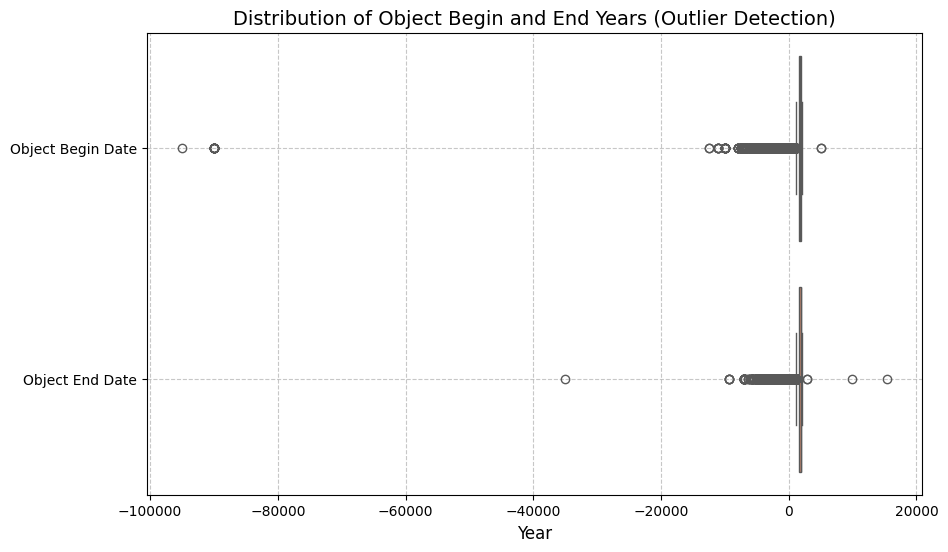

In [ ]:
# 1. Select the columns
date_cols = ['Object Begin Date', 'Object End Date']

# 2. Create the Box Plot
plt.figure(figsize=(10, 6))

sns.boxplot(data=MODIFIED_DATASET[date_cols], orient='h', palette="Set2")

# 3. Add Labels and Title
plt.title('Distribution of Object Begin and End Years (Outlier Detection)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

# TODO delete after it's added in profiling

In [ ]:
target_cols = ['Object Begin Date', 'Object End Date']

print("--- Extreme Values Analysis ---")

for col in target_cols:
    # 4. Find the Index of the Min and Max values
    # idxmin() returns the row number (index) where the minimum value is found
    min_idx = MODIFIED_DATASET[col].idxmin()
    max_idx = MODIFIED_DATASET[col].idxmax()
    
    # 5. Extract the full rows using .loc[]
    row_min = MODIFIED_DATASET.loc[min_idx]
    row_max = MODIFIED_DATASET.loc[max_idx]
    
    print(f"\nCOLUMN: {col}")
    print(f"▼ Lowest Value: {MODIFIED_DATASET[col].min()} (Index: {min_idx})")
    
    print(f"▲ Highest Value: {MODIFIED_DATASET[col].max()} (Index: {max_idx})")

    # TODO Temporary

--- Extreme Values Analysis ---

COLUMN: Object Begin Date
▼ Lowest Value: -95000 (Index: 379043)
▲ Highest Value: 5000 (Index: 349274)

COLUMN: Object End Date
▼ Lowest Value: -35000 (Index: 379043)
▲ Highest Value: 15335 (Index: 102825)


In [ ]:
target_index = 349274  

print(f"--- Full Data for Row {target_index} ---")
print(MODIFIED_DATASET.loc[target_index])
#MODIFIED_DATASET.loc[400509, 'Object Begin Date'] = 1859
#MODIFIED_DATASET.loc[400509, 'Object End Date'] = 1861
#MODIFIED_DATASET.loc[112028, 'Object End Date'] = 1575
#MODIFIED_DATASET.loc[112025, 'Object End Date'] = 1535

# TODO Temporary, bad practice analyzing rows one at a time to fix them

--- Full Data for Row 349274 ---
Object Number                                                  89.4.1612
Is Highlight                                                       False
Is Public Domain                                                    True
Object ID                                                         502176
Department                                           Musical Instruments
Object Name                                                         Bell
Title                                                               Bell
Artist Role                                                             
Artist Display Name                                                     
Artist Alpha Sort                                                       
Object Begin Date                                                   5000
Object End Date                                                        1
Medium                                                             Metal
Dimensions        

In [ ]:
# Test cell 
print(MODIFIED_DATASET.isnull().sum())
print(MODIFIED_DATASET.dtypes)

Object Number          0
Is Highlight           0
Is Public Domain       0
Object ID              0
Department             0
Object Name            0
Title                  0
Artist Role            0
Artist Display Name    0
Artist Alpha Sort      0
Object Begin Date      0
Object End Date        0
Medium                 0
Dimensions             0
Credit Line            0
Classification         0
Link Resource          0
dtype: int64
Object Number          object
Is Highlight             bool
Is Public Domain         bool
Object ID               int64
Department             object
Object Name            object
Title                  object
Artist Role            object
Artist Display Name    object
Artist Alpha Sort      object
Object Begin Date       int64
Object End Date         int64
Medium                 object
Dimensions             object
Credit Line            object
Classification         object
Link Resource          object
dtype: object
